In [1]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2
from glob import glob
import os
from os import listdir
from os.path import isfile, join
import tensorflow.keras.utils as utils
%matplotlib inline

Data exploration

In [2]:
x_train_path = '../input/fashionpedia/dataset/train'
y_train_path = '../input/fashionpedia/dataset/segmented_train'

x_test_path = '../input/fashionpedia/dataset/test'
y_test_path = '../input/fashionpedia/dataset/segmented_test'


#appending the paths of train and test images
x_train = sorted([f'{x_train_path}/{f}' for f in listdir(x_train_path) if isfile(join(x_train_path, f))])
y_train = sorted([f'{y_train_path}/{f}' for f in listdir(y_train_path) if isfile(join(y_train_path, f))])

y_test = sorted([f'{y_test_path}/{f}' for f in listdir(y_test_path) if isfile(join(y_test_path, f))])
x_test = []
# not all of the test images are segmented so I select only segmented ones
for y in y_test:
    x_test.append(f'{x_test_path}/{os.path.basename(y.replace("_seg.png", ".jpg"))}')
  
print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

45623
45623
1158
1158


Custom Data Generator - its purpose is to return raw image as input and grayscale mask as a label of the input

In [3]:
class CustomDataGen(utils.Sequence):
    
    def __init__(self, X, Y, batch_size = 128, input_size=(128, 128, 3)):
        
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.input_size = input_size
        
        self.n = len(self.X)

    
    def on_epoch_end(self):
        pass

    def __get_input_output(self, x_path, y_path):
        x = cv2.imread(x_path)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB).astype(np.float32)
        x = cv2.resize(x, (self.input_size[0], self.input_size[1]))

        y = cv2.imread(y_path)
        y = cv2.resize(y, (self.input_size[0], self.input_size[1]),interpolation = cv2.INTER_NEAREST)
        y = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
        
        return x, y
    
    def __get_data(self, index, batches):
        X_batch ,Y_batch = [], []

        x_batch = self.X[index:batches]
        y_batch = self.Y[index:batches]

        for i, x in enumerate(x_batch):
            x, y = self.__get_input_output(x, y_batch[i])
            X_batch.append(x)
            Y_batch.append(y)
        return X_batch, Y_batch

    def __getitem__(self, index):

        X, Y = self.__get_data(index * self.batch_size, (index + 1) * self.batch_size) 
        return np.array(X), np.array(Y)

    def __len__(self):
        return self.n // self.batch_size

Showing example images from the batches created by DataGenerator

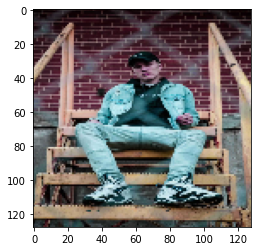

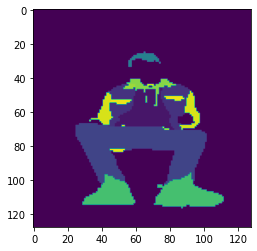

In [4]:
#training batch
train_datagen = CustomDataGen(x_train, y_train)
plt.imshow(train_datagen.__getitem__(2)[0][31]/255)
plt.show()
plt.imshow(train_datagen.__getitem__(2)[1][31]/255)
plt.show()

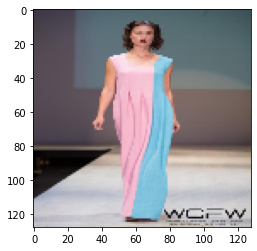

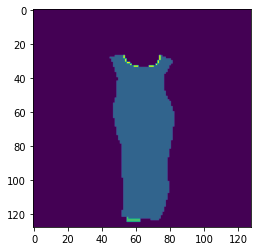

In [5]:
#testing batch
test_datagen = CustomDataGen(x_test, y_test)
plt.imshow(test_datagen.__getitem__(2)[0][0]/255)
plt.show()
plt.imshow(test_datagen.__getitem__(2)[1][0]/255)
plt.show()

Creating the DeepLabV3 model

In [6]:
img_height, img_width, channels = 128, 128, 3
num_classes = 47

In [7]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=img_height, num_classes=num_classes)
model.summary()

2022-04-07 10:49:06.789167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 10:49:06.956366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 10:49:06.957262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 10:49:06.958677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_____________________________

Training

2022-04-07 10:49:15.502409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-07 10:49:24.661359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-04-07 10:49:31.340370: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


356/356 [==============================] - 1423s 4s/step - loss: 0.4863 - accuracy: 0.8755 - val_loss: 0.3695 - val_accuracy: 0.9061
Epoch 2/40
356/356 [==============================] - 861s 2s/step - loss: 0.3222 - accuracy: 0.9066 - val_loss: 0.3837 - val_accuracy: 0.9055
Epoch 3/40
356/356 [==============================] - 864s 2s/step - loss: 0.2851 - accuracy: 0.9160 - val_loss: 0.2910 - val_accuracy: 0.9186
Epoch 4/40
356/356 [==============================] - 855s 2s/step - loss: 0.2568 - accuracy: 0.9235 - val_loss: 0.3178 - val_accuracy: 0.9158
Epoch 5/40
356/356 [==============================] - 847s 2s/step - loss: 0.2382 - accuracy: 0.9286 - val_loss: 0.2770 - val_accuracy: 0.9218
Epoch 6/40
356/356 [==============================] - 844s 2s/step - loss: 0.2213 - accuracy: 0.9333 - val_loss: 0.2872 - val_accuracy: 0.9225
Epoch 7/40
356/356 [==============================] - 854s 2s/step - loss: 0.2030 - accuracy: 0.9385 - val_loss: 0.2977 - val_accuracy: 0.9196
Epoch 8/4

2022-04-07 20:40:04.400127: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


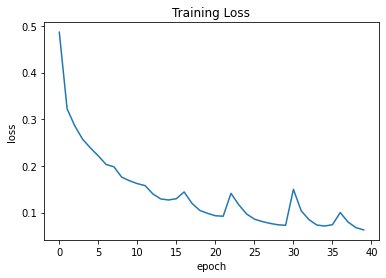

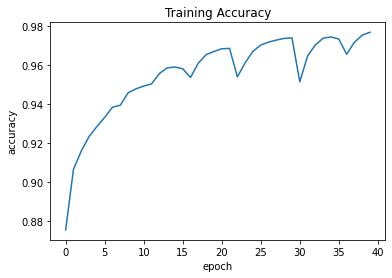

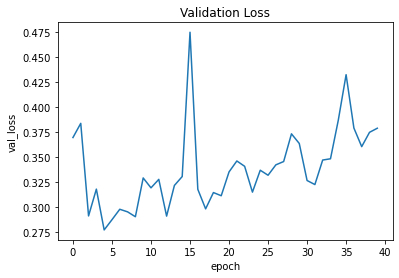

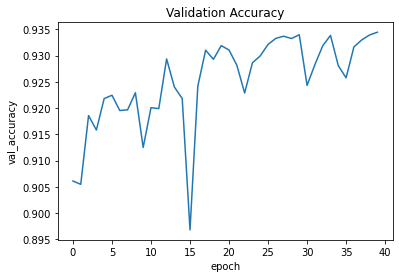

In [8]:
# Loss, which is categorical cross entropy but with true labels instead of one hot encoded 
# - easier for segmentation, because we cannot one hot encode every label in a 128x128 image
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

#train
history = model.fit(train_datagen, validation_data=test_datagen, batch_size = 32,epochs=40)
model.save('DeepLab_clothing')

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

Running predictions

In [9]:
def predict_and_plot(index,name):
    img1 = cv2.imread(x_test[index])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB).astype(np.float32)
    img1 = cv2.resize(img1, (img_height,img_width))
    pred1 = model.predict((np.expand_dims((img1), axis=0)))
    pred1 = np.squeeze(pred1)
    pred1 = np.argmax(pred1, axis=2)
    seg1 = cv2.imread(y_test[index])
    seg1 = cv2.cvtColor(seg1, cv2.COLOR_BGR2GRAY).astype(np.float32)
    seg1 = cv2.resize(seg1, (img_height,img_width))
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.title('original')
    plt.imshow(img1/255)
    plt.subplot(1,3,2)
    plt.title('prediction')
    plt.imshow(pred1)
    plt.subplot(1,3,3)
    plt.title('original segmentation')
    plt.imshow(seg1)
    plt.show()
    plt.savefig(name)

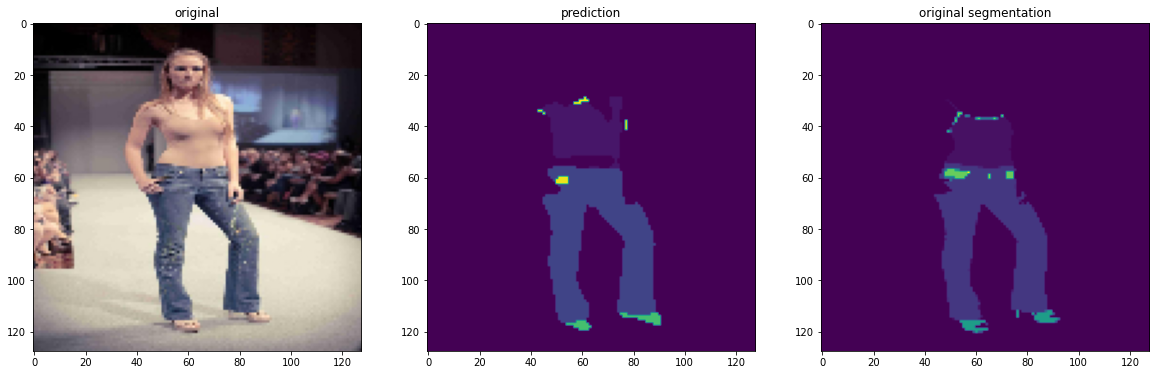

<Figure size 432x288 with 0 Axes>

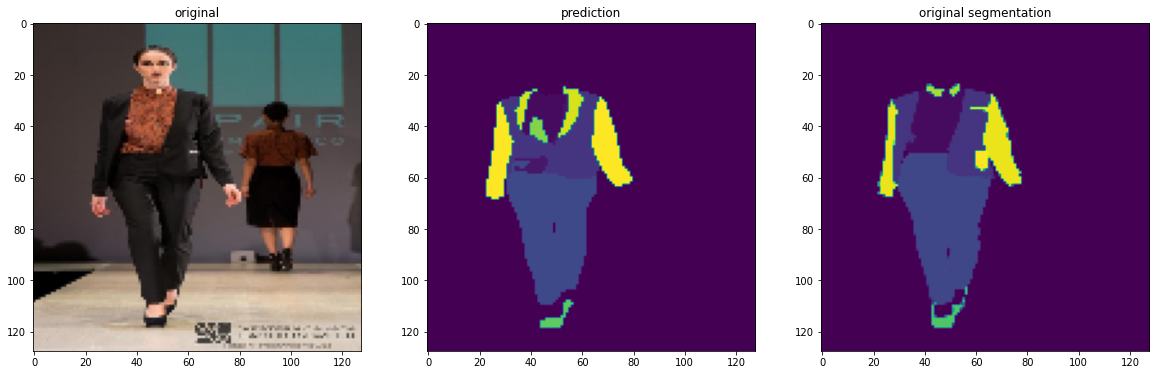

<Figure size 432x288 with 0 Axes>

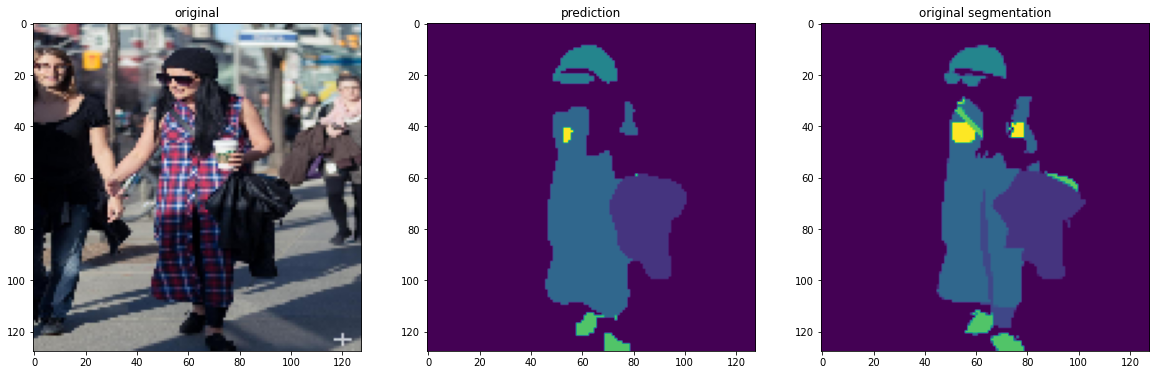

<Figure size 432x288 with 0 Axes>

In [10]:
predict_and_plot(5,'fig1.png')
predict_and_plot(16,'fig2.png')
predict_and_plot(38,'fig3.png')